In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv' )

In [3]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
sales_data = df.groupby('Order Date')['Sales'].sum().reset_index()
sales_data = sales_data.sort_values('Order Date')

In [4]:
sales_data_old = sales_data.copy()

In [5]:
sales_data.head(5)

,Order Date,Sales
0,2015-01-03,16.448
1,2015-01-04,288.060
2,2015-01-05,19.536
3,2015-01-06,4407.100
4,2015-01-07,87.158


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
sales_data['Sales'] = scaler.fit_transform(sales_data['Sales'].values.reshape(-1, 1))

In [7]:
sales_data.head()

,Order Date,Sales
0,2015-01-03,0.000513
1,2015-01-04,0.010177
2,2015-01-05,0.000623
3,2015-01-06,0.156738
4,2015-01-07,0.003029


In [8]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [9]:
sequence_length = 25
X, y = create_sequences(sales_data['Sales'].values, sequence_length)

In [10]:

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(964, 25) (241, 25) (964,) (241,)


In [11]:
model = Sequential([
    LSTM(500, return_sequences=True, input_shape=(sequence_length, 1), activation='tanh'),
    LSTM(500, return_sequences=False, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [13]:
history = model.fit(X_train_reshaped, y_train, epochs=500, batch_size=12, validation_data=(X_test_reshaped, y_test))
train_loss = model.evaluate(X_train_reshaped, y_train)
test_loss = model.evaluate(X_test_reshaped, y_test)

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')


Epoch 1/500
81/81 [==============================] - 29s 317ms/step - loss: 0.0065 - val_loss: 0.0080
Epoch 2/500
81/81 [==============================] - 23s 279ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 3/500
81/81 [==============================] - 18s 223ms/step - loss: 0.0064 - val_loss: 0.0077
Epoch 4/500
81/81 [==============================] - 20s 244ms/step - loss: 0.0065 - val_loss: 0.0087
Epoch 5/500
81/81 [==============================] - 20s 242ms/step - loss: 0.0064 - val_loss: 0.0091
Epoch 6/500
81/81 [==============================] - 36s 449ms/step - loss: 0.0064 - val_loss: 0.0079
Epoch 7/500
81/81 [==============================] - 34s 421ms/step - loss: 0.0064 - val_loss: 0.0085
Epoch 8/500
81/81 [==============================] - 33s 410ms/step - loss: 0.0064 - val_loss: 0.0082
Epoch 9/500
81/81 [==============================] - 31s 382ms/step - loss: 0.0064 - val_loss: 0.0086
Epoch 10/500
81/81 [==============================] - 30s 369ms/step - loss: 0.006

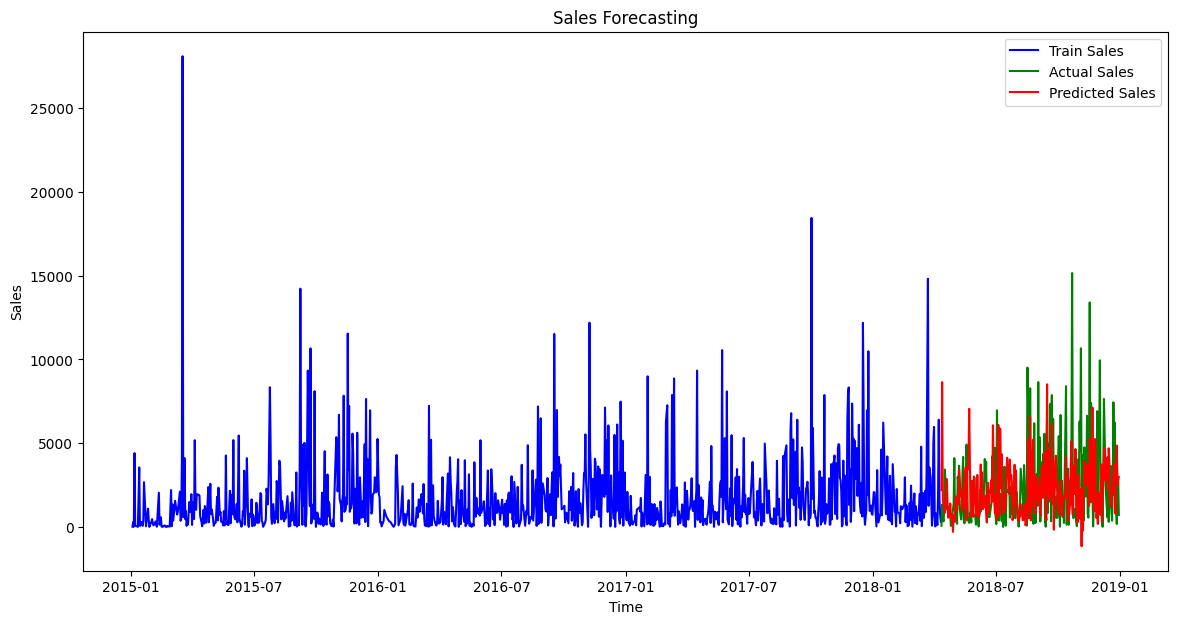

In [14]:
predictions = model.predict(X_test_reshaped)

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Extract dates for plotting
train_dates = sales_data_old['Order Date'][:train_size + sequence_length]
test_dates = sales_data_old['Order Date'][train_size + sequence_length:]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_dates, sales_data_old['Sales'][:train_size + sequence_length], color='blue', label='Train Sales')
plt.plot(test_dates, y_test_scaled, color='green', label='Actual Sales')
plt.plot(test_dates, predictions, color='red', label='Predicted Sales')
plt.title('Sales Forecasting')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [18]:
model.save("lstmModel.h5")